### VAU-12 - Демонстрация работы модели advanced автоенкодера
#### Работу выполнил Вологин Никита Сергеевич

Задача модели, используемой в этом ноутбуке, состоит в определении аномальных значений, которые в контексте предметной области определены как блюда неправильной сервировки. 
В качестве рабочей гипотезы было сформулировано: "Ошибка реконструкции изображений, которые похожи на изображения, находящиеся в обучающем наборе данных, будет меньше, чем у изображений аномальной природы".

Данный ноутбук содержит демонстрационный код работы модели advanced автоекодера, обученных на наборах данных DSM-100 и DSM-50.

##### Импорт необходимых зависимостей

In [4]:
import numpy as np

from tensorflow import keras
from keras import saving as sv

import models.advanced_autoencoder as adv_cae

import scripts.utilities as utl

##### Определение глобальных констант

In [27]:
BATCH_SIZE = 64
IMG_SIZE = 128
IMG_100_PATH = 'data/DSM-100/images'
ANO_IMG_100_PATH = 'data/DSM-100/ANO-DSM/uncorrect-meals/images'
ANO_IMG_100_PATH2 = 'data/DSM-100/ANO-DSM/unknown-meals/images'

IMG_50_PATH = 'data/DSM-50/images'
ANO_IMG_50_PATH = 'data/DSM-50/ANO-DSM/uncorrect-meals/images'
ANO_IMG_50_PATH2 = 'data/DSM-50/ANO-DSM/unknown-meals/images'

TEST_IMG_PATH = 'data/test-images/correct'
TEST_ANO_IMG_PATH = 'data/test-images/incorrect'

ADV_MODEL_TEST_50_PATH = 'trained-models/adv_model_50_with_test.keras'
ADV_MODEL_TEST_100_PATH = 'trained-models/adv_model_100_with_test.keras'

ADV_MODEL_50_PATH = 'trained-models/dsm-50/adv_model_50.weights.h5'
ADV_MODEL_100_PATH = 'trained-models/dsm-100/adv_model_100.weights.h5'

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
RANDOM_SEED = 42

#### Импорт, предобработка и аугментация данных

In [28]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.5, 1],
    validation_split=0.2)

ano_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_dataget = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [29]:
test_generator = test_dataget.flow_from_directory(
    TEST_IMG_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

test_ano_generator = test_dataget.flow_from_directory(
    TEST_ANO_IMG_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

Found 3 images belonging to 1 classes.
Found 3 images belonging to 1 classes.


In [30]:
train_generator_50 = train_datagen.flow_from_directory(
    IMG_50_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

valid_generator_50 = train_datagen.flow_from_directory(
    IMG_50_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='validation',
    seed=RANDOM_SEED
)

unknown_ano_generator_50 = ano_datagen.flow_from_directory(
    ANO_IMG_50_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

uncorrect_ano_generator_50 = ano_datagen.flow_from_directory(
    ANO_IMG_50_PATH2,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

Found 148 images belonging to 45 classes.
Found 7 images belonging to 45 classes.


Found 71 images belonging to 26 classes.
Found 349 images belonging to 55 classes.


In [31]:
train_generator_100 = train_datagen.flow_from_directory(
    IMG_100_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

valid_generator_100 = train_datagen.flow_from_directory(
    IMG_100_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='validation',
    seed=RANDOM_SEED
)

unknown_ano_generator_100 = ano_datagen.flow_from_directory(
    ANO_IMG_100_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

uncorrect_ano_generator_100 = ano_datagen.flow_from_directory(
    ANO_IMG_100_PATH2,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='input',  
    subset='training',
    seed=RANDOM_SEED  
)

Found 309 images belonging to 84 classes.
Found 26 images belonging to 84 classes.
Found 156 images belonging to 48 classes.
Found 115 images belonging to 22 classes.


#### Пример изображений блюд

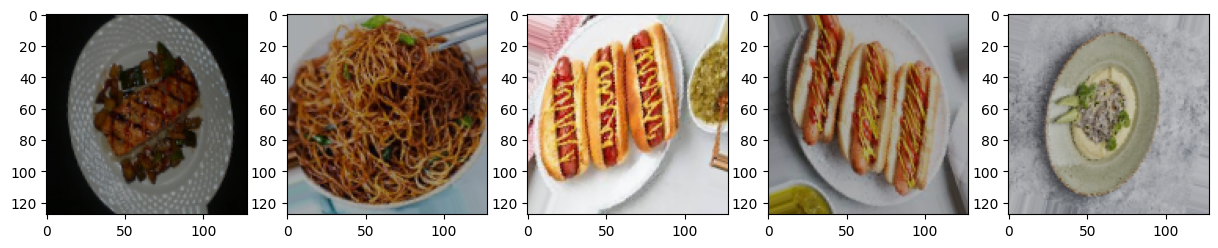

In [32]:
utl.plot_imgs(train_generator_100)

#### Загрузка и инициализация моделей

In [33]:
inc_model_50 = adv_cae.Autoencoder(shape=IMG_SHAPE)
inc_model_50.load_weights(ADV_MODEL_50_PATH, skip_mismatch=True)
inc_model_100 = adv_cae.Autoencoder(shape=IMG_SHAPE)
inc_model_100.load_weights(ADV_MODEL_100_PATH, skip_mismatch=True)

In [34]:
inc_model_100.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mean_squared_error',
)
inc_model_50.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mean_squared_error',
)

#### Примеры реконструкции изображений

Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-100


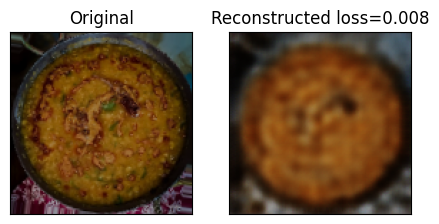

Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-50


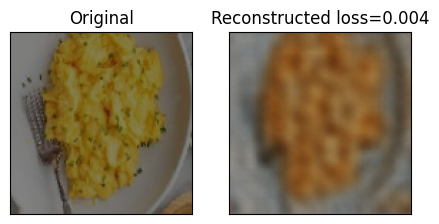

In [35]:
print('Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(valid_generator_100, 1, inc_model_100)

print('Пример реконструкции тестовых данных с помощью модели inception cae, обученной на наборе dsm-50')
utl.plot_rec_imgs(valid_generator_50, 1, inc_model_50)

Пример реконструкции неизвестных блюд с помощью модели inception cae, обученной на наборе dsm-100


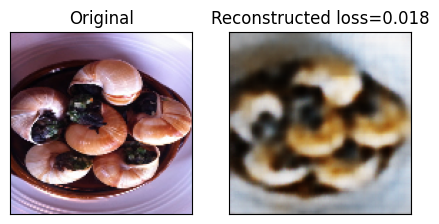

Пример реконструкции неизвестных блюд с модели inception cae, обученной на наборе dsm-50


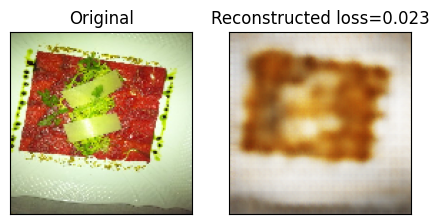

In [36]:
print('Пример реконструкции неизвестных блюд с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(unknown_ano_generator_100, 1, inc_model_100)

print('Пример реконструкции неизвестных блюд с модели inception cae, обученной на наборе dsm-50')
utl.plot_rec_imgs(unknown_ano_generator_50, 1, inc_model_50)

Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100


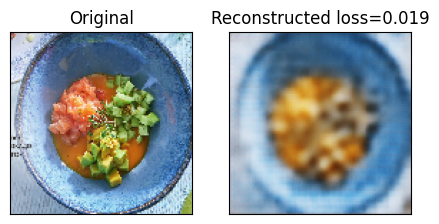

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50


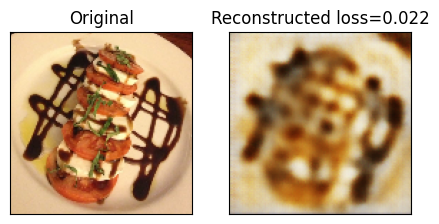

In [37]:
print('Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(uncorrect_ano_generator_100, 1, inc_model_100)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50')
utl.plot_rec_imgs(uncorrect_ano_generator_50, 1, inc_model_50)

Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100


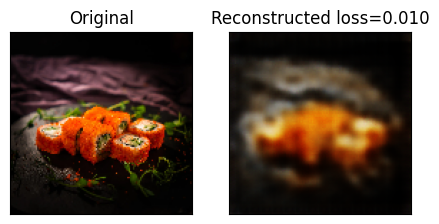

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50


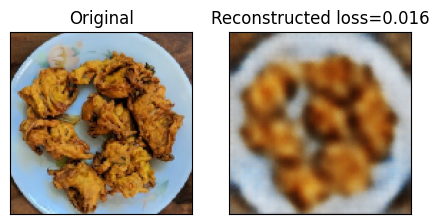

In [38]:
print('Пример реконструкции блюд с неправильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(uncorrect_ano_generator_100, 1, inc_model_100)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50')
utl.plot_rec_imgs(uncorrect_ano_generator_50, 1, inc_model_50)

Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100


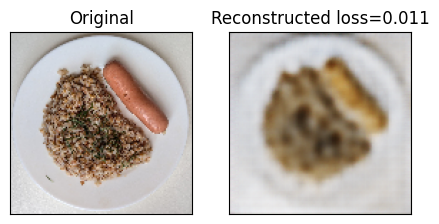

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-100


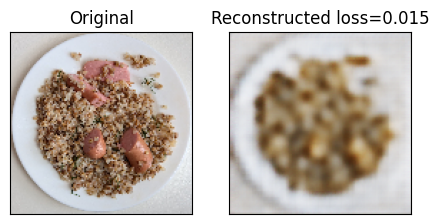

In [39]:
print('Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-100')
utl.plot_rec_imgs(test_generator, 1, inc_model_100)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-100')
utl.plot_rec_imgs(test_ano_generator, 1, inc_model_100)

Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-50


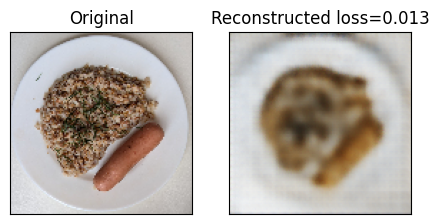

Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50


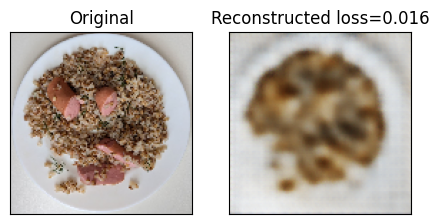

In [40]:
print('Пример реконструкции тестового блюда с правильной сервировкой с помощью модели inception cae, обученной на наборе dsm-50')
utl.plot_rec_imgs(test_generator, 1, inc_model_50)

print('Пример реконструкции блюд с неправильной сервировкой с помощью обычной модели, обученной на наборе dsm-50')
utl.plot_rec_imgs(test_ano_generator, 1, inc_model_50)

#### Вычисление ошибки реконструкции на каждом примере

##### DSM-100

In [47]:
train_recon_error_list = utl.get_error(train_generator_100, inc_model_100, BATCH_SIZE)
test_recon_error_list = utl.get_error(valid_generator_100, inc_model_100, BATCH_SIZE)

uncorrect_ano_recon_error_list = utl.get_error(uncorrect_ano_generator_100, inc_model_100, BATCH_SIZE)
unknown_ano_recon_error_list = utl.get_error(unknown_ano_generator_100, inc_model_100, BATCH_SIZE)

clean = np.append(test_recon_error_list, train_recon_error_list)
fraud = np.append(uncorrect_ano_recon_error_list, unknown_ano_recon_error_list)
threshold = np.mean(clean) + np.std(clean)

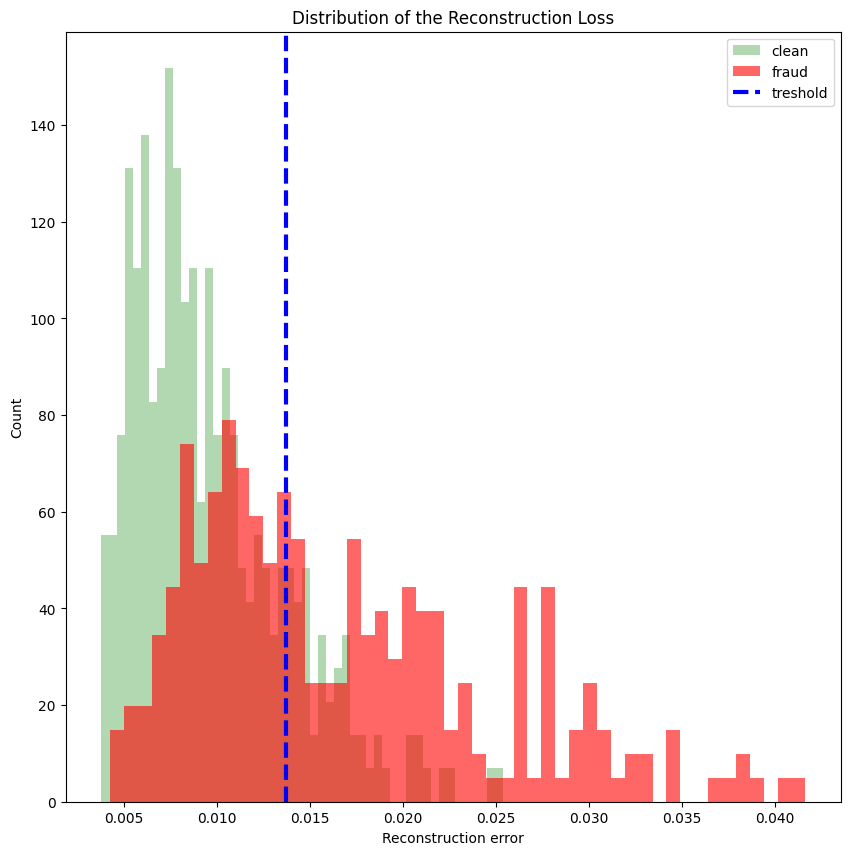

In [48]:
utl.plot_rec_distribution(clean, fraud, threshold)

In [49]:
ano_grechka_recon_error_list = utl.get_error(test_ano_generator, inc_model_100, BATCH_SIZE)
grechka_recon_error_list = utl.get_error(test_generator, inc_model_100, BATCH_SIZE)

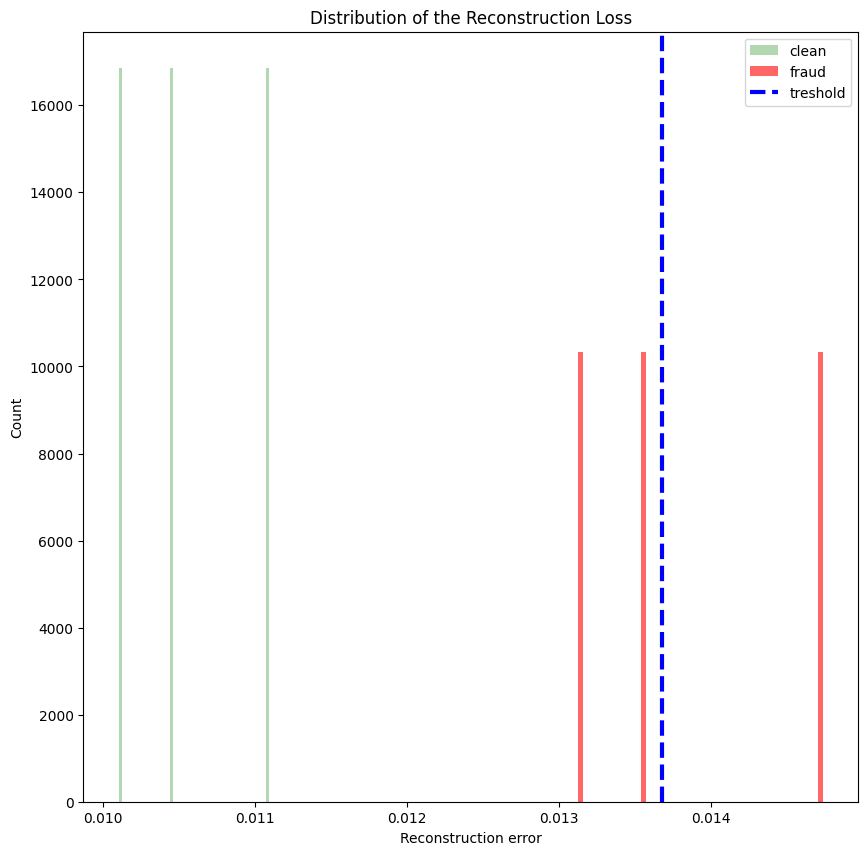

In [50]:
utl.plot_rec_distribution(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)

In [51]:
a, b, c, d = utl.get_classification_metrics(clean, fraud, threshold)
utl.print_classification_metrics(a, b, c, d )

precisicon 0.685
recall 0.830
F 0.750
accuracy: 0.695


In [52]:
a, b, c, d = utl.get_classification_metrics(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)
utl.print_classification_metrics(a, b, c, d )

precisicon 0.600
recall 1.000
F 0.750
accuracy: 0.667


#### Промежуточный вывод

Как можно видеть по графику, нормальная сервировка и аномальная довольно хорошо различимы, однако разделительная линия, вычисленная на основном наборе данных, получилась неудачной для разделения.

In [53]:
train_recon_error_list = utl.get_error(train_generator_50, inc_model_50, BATCH_SIZE)
test_recon_error_list = utl.get_error(valid_generator_50, inc_model_50, BATCH_SIZE)

uncorrect_ano_recon_error_list = utl.get_error(uncorrect_ano_generator_50, inc_model_50, BATCH_SIZE)
unknown_ano_recon_error_list = utl.get_error(unknown_ano_generator_50, inc_model_50, BATCH_SIZE)

clean = np.append(test_recon_error_list, train_recon_error_list)
fraud = np.append(uncorrect_ano_recon_error_list, unknown_ano_recon_error_list)
threshold = np.mean(clean) + np.std(clean)

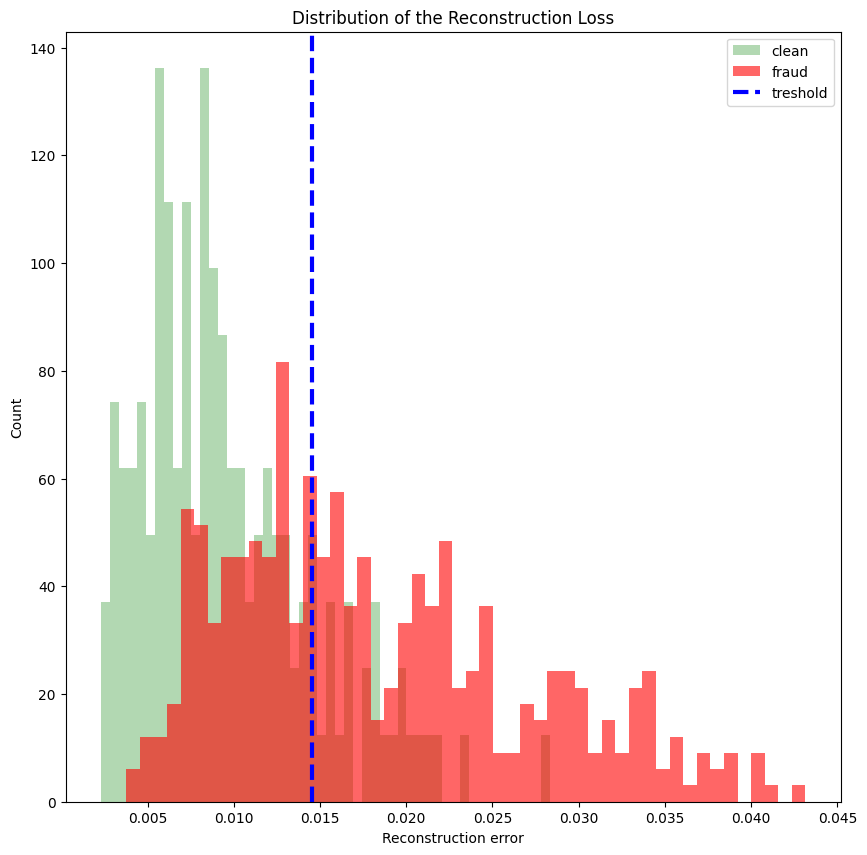

In [54]:
utl.plot_rec_distribution(clean, fraud, threshold)

In [55]:
grechka_recon_error_list = utl.get_error(test_generator, inc_model_50, BATCH_SIZE)
ano_grechka_recon_error_list = utl.get_error(test_ano_generator, inc_model_50, BATCH_SIZE)

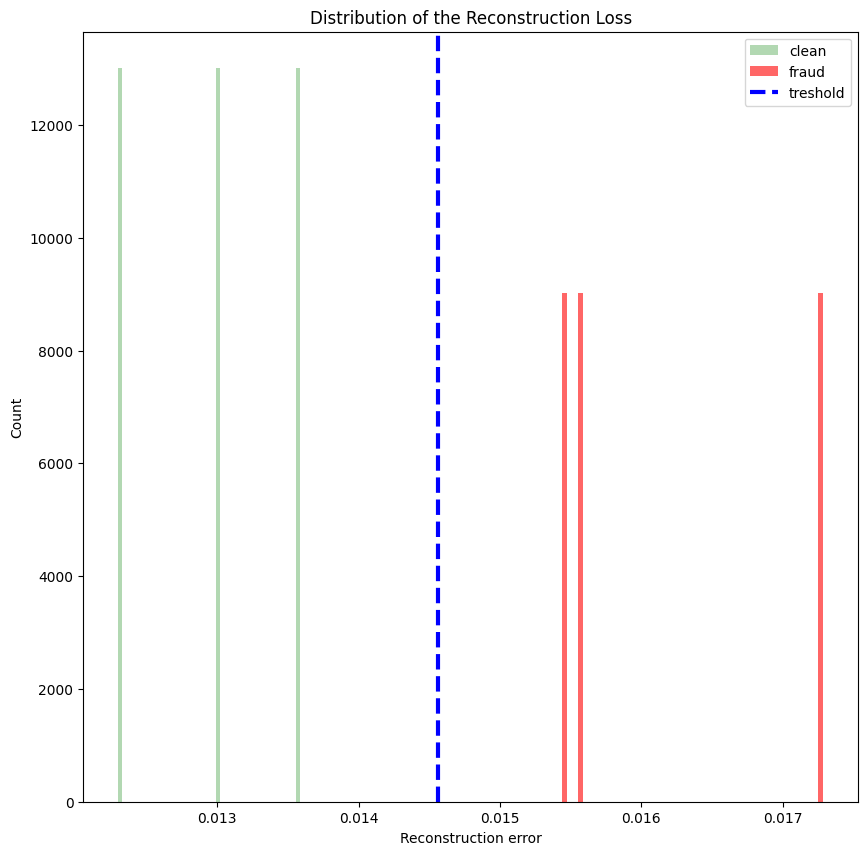

In [56]:
utl.plot_rec_distribution(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)

In [57]:
a, b, c, d = utl.get_classification_metrics(clean, fraud, threshold)
utl.print_classification_metrics(a, b, c, d )

precisicon 0.434
recall 0.845
F 0.573
accuracy: 0.661


In [58]:
a, b, c, d = utl.get_classification_metrics(grechka_recon_error_list, ano_grechka_recon_error_list, threshold)
utl.print_classification_metrics(a, b, c, d )

precisicon 1.000
recall 1.000
F 1.000
accuracy: 1.000


#### Промежуточный вывод

Как можно видеть по графику, разделение в этот раз получилось идеальным. Набор DSM-50 в данном случае показал себя лучше.

#### Выводы

* Точность классификации обеих моделей на их основных наборах оставляет желать лучшего, advanced cae с разделением DSM наборов справялется плохо.
* Таким образом, на основе собранных наборов данных DSM-50 и DSM-100 удалось обучить модель автоенкодера, которая подтверждает установленную гипотезу. 
  
В контексте предметной области это означает, что установить схожесть приготовленного блюда с эталонном блюдом с помощью методов машинного обучения и малого обучающего набора данных возможно с приемлемой точностью. 

Кроме того, пусть точность классификации на основных наборах данных оставляет желать лучшего, но результат на тестовых данных показал, что этот вариант архитектуры автоенкодера справляется лучше, чем inception cae. 